In [19]:
!pip install lpips

In [29]:
# 1. Library imports
import torch
import io, json
import base64
import PIL.Image as Image
import numpy as np
import lpips
import torchvision
from torch.autograd import Variable
from matplotlib import pyplot as plt # for debugging purposes
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter



<ipython-input-29-e5bd1b2cff6c>:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [ ]:
loss_fn = lpips.LPIPS(net='vgg',version=0.1)
loss_fn.cuda()


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 394MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


LPIPS(
  (scaling_layer): ScalingLayer()
  (net): vgg16(
    (slice1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (slice2): Sequential(
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
    )
    (slice3): Sequential(
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%ls /content/drive/MyDrive/ARLabels

background.jpg  test_backgroundAndLabel.jpg  test_mask.jpg


In [ ]:
b_path = "/content/drive/MyDrive/ARLabels/background.jpg"
b_w_l_path = "/content/drive/MyDrive/ARLabels/test_backgroundAndLabel.jpg"
labelMask_path = "/content/drive/MyDrive/ARLabels/test_mask.jpg"
backgroundImg = np.asarray(Image.open(b_path))
backgroundAndLabelImg = np.asarray(Image.open(b_w_l_path))
labelMaskImg = (1/255)*np.asarray(Image.open(labelMask_path))


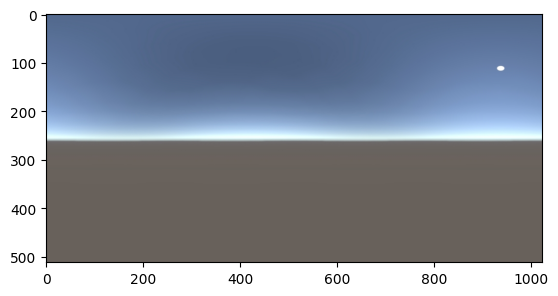

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(backgroundImg)


In [34]:
MAX_ITER = 1000
costList = []

backgroundImgAsTensor = lpips.im2tensor(lpips.load_image(b_path))
# The predicted image
pred = Variable(lpips.im2tensor(lpips.load_image(b_w_l_path)), requires_grad=True)

# label mask (boolean mask with True where label pixels are)
labelMaskAsTensor = lpips.im2tensor(lpips.load_image(labelMask_path)) > 0

optimizer = torch.optim.Adam([pred,], lr=0.01, betas=(0.9, 0.999))

distanceThreshold = 0.23


In [ ]:
import numpy as np

# Create a sample NumPy array (replace this with your actual array)
arr = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])

# Calculate differences between neighboring elements along rows (axis=1)
row_diff = np.diff(arr, axis=1)

# Calculate differences between neighboring elements along columns (axis=0)
col_diff = np.diff(arr, axis=0)

print("Row Differences:")
print(row_diff)

print("Column Differences:")
print(col_diff)


Row Differences:
[[1 1]
 [1 1]
 [1 1]]
Column Differences:
[[3 3 3]
 [3 3 3]]


In [22]:
def pixel_distance_loss(maskedLabel, weigth = 0.1):
  image = maskedLabel.permute(2, 3, 1, 0).detach().numpy()
  image = image.squeeze()
  # plt.imshow(image)
  image = np.where(image < 0, 0, image)


  diff = np.sum(np.abs(np.diff(image, axis=0))) + np.sum(np.abs(np.diff(image, axis=1)))
  diff_weight = diff / image.size

  x = torch.tensor([diff_weight])
  return x.cuda()


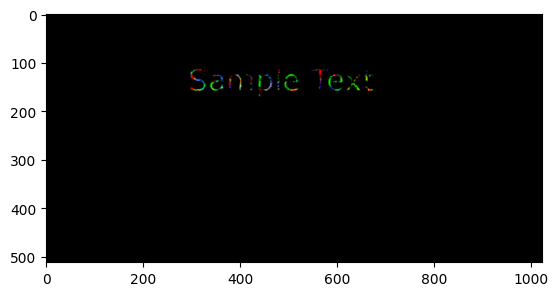

In [73]:
def blur_masked_label(maskedLabel):
  image = maskedLabel.permute(2, 3, 1, 0).detach().numpy()
  image = image.squeeze()
  blurred_image = np.empty_like(image)

  black_mask = np.all(image != [0, 0, 0], axis=-1)

  for channel in range(3):
    blurred_image[:, :, channel] = gaussian_filter(image[:, :, channel] * black_mask, sigma=1)

  # plt.imshow(blurred_image)
  blurred_image = np.expand_dims(blurred_image, axis=-1)
  blurred_image = np.transpose(blurred_image, (3, 2, 0, 1))
  return torch.tensor(blurred_image)

# maskedLabelTensor = pred.where(labelMaskAsTensor, -1) # sets all non-label pixels to 1
# maskedLabelTensor = blur_masked_label(maskedLabelTensor)


  0%|          | 2/1000 [00:00<03:50,  4.32it/s]

iter 0, dist 0.271


 10%|█         | 102/1000 [00:19<02:53,  5.18it/s]

iter 100, dist 0.271


 20%|██        | 202/1000 [00:39<02:34,  5.15it/s]

iter 200, dist 0.271


 30%|███       | 302/1000 [00:58<02:15,  5.17it/s]

iter 300, dist 0.271


 40%|████      | 402/1000 [01:17<01:58,  5.04it/s]

iter 400, dist 0.271


 50%|█████     | 502/1000 [01:37<01:36,  5.17it/s]

iter 500, dist 0.271


 60%|██████    | 602/1000 [01:56<01:16,  5.17it/s]

iter 600, dist 0.271


 70%|███████   | 702/1000 [02:15<00:57,  5.20it/s]

iter 700, dist 0.271


 80%|████████  | 802/1000 [02:34<00:37,  5.21it/s]

iter 800, dist 0.271


 90%|█████████ | 902/1000 [02:54<00:18,  5.24it/s]

iter 900, dist 0.271


100%|█████████▉| 999/1000 [03:12<00:00,  5.18it/s]


Reached the last iteration
<class 'numpy.ndarray'>
CPU times: user 4min 48s, sys: 4.6 s, total: 4min 52s
Wall time: 3min 12s


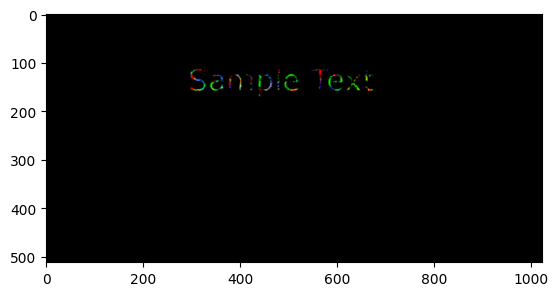

In [74]:
%%time

# Optimize
for iter in tqdm(range(MAX_ITER)):
    if type(backgroundAndLabelImg) == torch.Tensor:
        backgroundAndLabelImg = backgroundAndLabelImg.numpy()

    # Apply the boolean mask for label pixels
    # maskedLabelTensor = torch.mul(pred, labelMaskAsTensor)
    maskedLabelTensor = pred.where(labelMaskAsTensor, -1) # sets all non-label pixels to 1
    maskedLabelTensor = blur_masked_label(maskedLabelTensor)

    # Calculate the LPIPS loss: -1 * LPIPS distance between the current backgroundAndLabelImage and the backgroundImage
    LPIPSLoss = loss_fn.forward(maskedLabelTensor.cuda(), backgroundImgAsTensor.cuda())
    neg_loss = - LPIPSLoss - pixel_distance_loss(maskedLabelTensor)

    # Clear the gradient for a new calculation
    optimizer.zero_grad()

    # Do backpropagation based on the LPIPS loss above
    neg_loss.backward()

    # append the current loss term to costList to plot them later
    costList.append(LPIPSLoss[0][0][0][0].item())

    optimizer.step() # based on backpropagation implemented in lpips_loss.py

    # Print out losses/distances
    if iter % 100 == 0:
        print('iter %d, dist %.3g' % (iter, LPIPSLoss.view(-1).data.cpu().numpy()[0]))

    # Save the output image
    if (iter == MAX_ITER - 1):
        print('Reached the last iteration')
        pred.data = torch.clamp(pred.data, -1, 1)
        pred_img = lpips.tensor2im(pred.data)
        print(type(pred_img))
        break


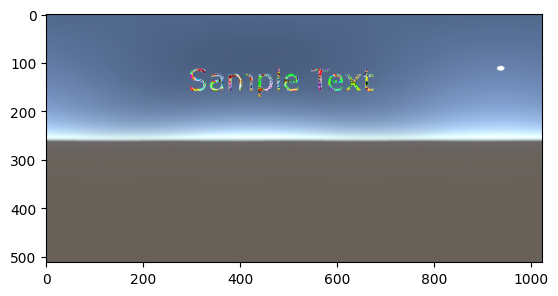

In [75]:
plt.imshow(pred_img)